# El problema de la diligencia
un cazafortunas mítico de Missouri que decide ir al oeste a sumergirse en la fiebre del oro que surgió en California a mediados del siglo xIX. Tiene que hacer el viaje en diligencia a través de territorios sin ley, donde existen serios peligros de ser atacado por merodeadores. A pesar de que su punto de partida y su destino son fijos, tiene muchas opciones en cuanto a qué estados —o territorios-
— debe elegir
como puntos intermedios.

Se muestran las rutas posibles, en donde cada estado se representa mediante un círculo con una letra; además, en el diagrama, la dirección del viaje es siempre de izquierda a derecha. Como se puede observar, se requieren cuatro etapas -
-jornadas
en diligencia- para viajar desde su punto de partida en el estado A (Missouri) a su destino en el estado J (California).

Este cazafortunas es un hombre prudente preocupado por su seguridad.

Después de reflexionar un poco ideó una manera bastante ingeniosa para determinar la ruta más segura. Se ofrecen pólizas de seguros de vida a los pasajeros.

Como el costo de la póliza de cualquier jornada en la diligencia está basado en una evaluación cuidadosa de la seguridad del recorrido, la ruta más segura debe ser aquella cuya póliza represente el menor costo total.

El costo de la póliza estándar del viaje en diligencia, del estado i al estado j, que se denota como cij es:
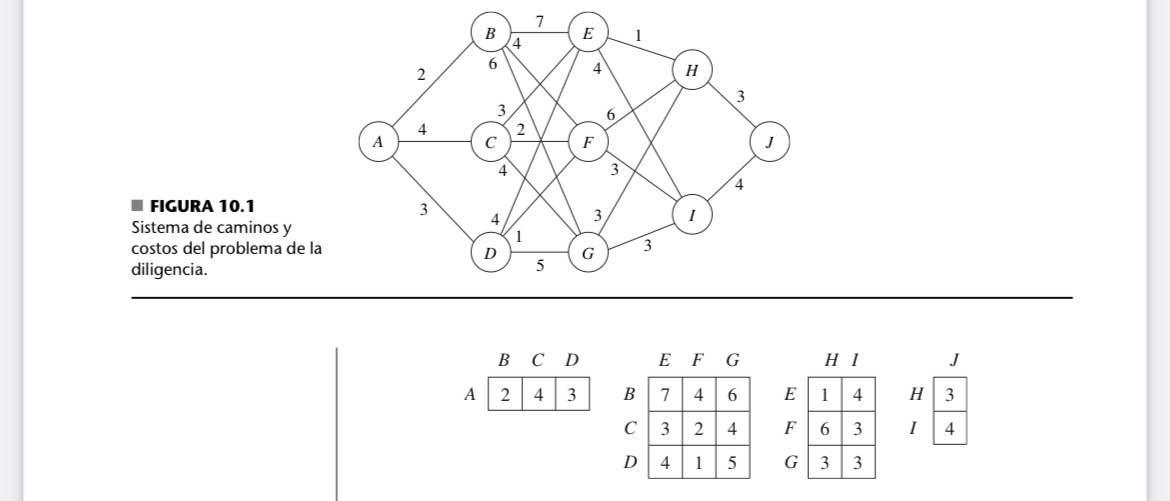

 ¿Cuál es la ruta que minimiza el costo total de la póliza?

#Formulacion del Problema
**V.D**
Sean Xn (n = 1,2,3,4) Las variables de decision  que representan el destino inmediato de la etapa n(el n-esimo viaje que se hara en diligencia). EN este caso la ruta seleccionada es A - x1 - x2 - x3 - x4, donde x4 = J
Sea fn(s,Xn) el costo total de la mejor politica global para enfrentar las etapas restantes, mientras el agente de ventas se encuentra en el estado s, listo para iniciar la etapa y elige Xn como destino inmediato.

Dados s y n, sea X*,n el valor de Xn - no necesariamente unico-  minimiza fn(s,xn), y sea f*,n(s) el valor minimo correspondiente de fn(s,Xn)
**Funcion Objetivo**
Entonces:
f*n(s) = min fn(s,xn) = fn(s,x*,n),
donde fn(s,xn) = costo inmediato (etapa n) + costo futuro minimo(etapas n + 1 en adelante)
= Csxn + (f*,n+1)(Xn)
El valor de Csxn esta dado por las tablas anteriores para cij establecer i = s (el estado actual) y j = Xn (el destino inmediato). Como el destino final (Estado J) se alcanza al terminar la etapa 4, f*,5(J) = 0

El objetivo es encontrar f*,1(A) y la ruta correspondiente. La programacion dinamica la encuentra al determinar en forma sucesiva f*,4(s), f*,3(s), f*,2(s) para cada uno de los estados posibles de s y usar despues f*,2(s) para encontrar f*,1(A)

In [3]:
!pip install -q pyomo
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install -c conda-forge glpk
import pyomo.environ as pyo
from pyomo.opt import SolverFactory

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 86.8 MB/s eta 0:00:00
✨🍰✨ Everything looks OK!
Channels:
 - conda-forge
Platform: linux-64
Solving environment: \ | / done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.1.2

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



**Variables de Decision**

In [4]:
#Crear un modelo concreto en Pyomo

model = pyo.ConcreteModel()


# Definir los conjuntos basados en los nodos y arcos del grafo

nodos = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

arcos = [('A', 'B'), ('A', 'C'), ('A', 'D'),

         ('B', 'E'), ('B', 'F'), ('B','G'),('C','E'),('C', 'F'), ('C','G'),

         ('D','E'),('D','F'),('D', 'G'), ('E', 'H'), ('E','I'),('F', 'H'), ('F', 'I'),

         ('G','H'),('G', 'I'), ('H', 'J'), ('I', 'J')]



# Definir los costos de los arcos como un diccionario

costos = {('A', 'B'): 2, ('A', 'C'): 4, ('A', 'D'): 3,

          ('B', 'E'): 7, ('B', 'F'): 4, ('B', 'G'): 6,

          ('C', 'E'): 3, ('C', 'F'): 2, ('C', 'G'): 4,

          ('D', 'E'): 4, ('D', 'F'): 1, ('D', 'G'): 5,

          ('E', 'H'): 1, ('E','I'): 4,
          ('F','H'):6,('F','I'):3,
          ('G','H'):3,('G','I'):3,
          ('H','J'):3,('I','J'):4}



# Inicializar conjuntos en el modelo

model.Nodos = pyo.Set(initialize=nodos)

model.Arcos = pyo.Set(within=model.Nodos*model.Nodos, initialize=arcos)



# Parámetro para los costos

model.Costos = pyo.Param(model.Arcos, initialize=costos)



# Variable de decisión para el flujo en los arcos

model.flujo = pyo.Var(model.Arcos, within=pyo.NonNegativeReals, initialize=0)


**Funcion Objetivo**

In [5]:
# Función objetivo: minimizar el costo total del flujo

def obj_rule(model):

    return sum(model.flujo[i, j] * model.Costos[i, j] for i, j in model.Arcos)

model.Objetivo = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

**Reestricciones**

In [6]:
# Restricciones de conservación de flujo

def conservation_rule(model, n):

    # Nodo de salida

    inflows = sum(model.flujo[i, n] for i in model.Nodos if (i, n) in model.Arcos)

    # Nodo de entrada

    outflows = sum(model.flujo[n, j] for j in model.Nodos if (n, j) in model.Arcos)

    # Nodo de origen

    if n == 'A':

        return (inflows - outflows == -1)  # Sale un flujo de A

    # Nodo de destino

    elif n == 'J':

        return (inflows - outflows == 1)   # Entra un flujo en J

    # Nodos intermedios

    else:

        return (inflows == outflows)       # Entrada = Salida en nodos intermedios



model.Conservacion = pyo.Constraint(model.Nodos, rule=conservation_rule)



In [7]:
#Resolvemos el modelo con el solver 'glpk'
solver = SolverFactory('glpk')  # Usando GLPK
results = solver.solve(model, tee=True)


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmpuzde9yr4.glpk.raw --wglp /tmp/tmpe5a4n85t.glpk.glp --cpxlp
 /tmp/tmp0ddaovnl.pyomo.lp
Reading problem data from '/tmp/tmp0ddaovnl.pyomo.lp'...
10 rows, 20 columns, 40 non-zeros
119 lines were read
Writing problem data to '/tmp/tmpe5a4n85t.glpk.glp'...
95 lines were written
GLPK Simplex Optimizer 5.0
10 rows, 20 columns, 40 non-zeros
Preprocessing...
10 rows, 20 columns, 40 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 9
*     0: obj =   1.500000000e+01 inf =   0.000e+00 (5)
*     5: obj =   1.100000000e+01 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.0 Mb (39693 bytes)
Writing basic solution to '/tmp/tmpuzde9yr4.glpk.raw'...
39 lines were written


In [8]:
# Extraer la solución

ruta_optima = []

costo_minimo = pyo.value(model.Objetivo)



for arco in model.Arcos:

    flujo = pyo.value(model.flujo[arco])

    if flujo > 0:

        ruta_optima.append(arco)



(ruta_optima, costo_minimo)


([('A', 'D'), ('D', 'F'), ('F', 'I'), ('I', 'J')], 11.0)